## 2- Preparo dos Dados

#### Validando quantidades

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
i=pd.read_csv('~/comex/data/imp2.csv')

In [3]:
i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ANO     2357 non-null   int64
 1   MES     2357 non-null   int64
 2   NCM     2357 non-null   int64
 3   PAIS    2357 non-null   int64
 4   URF     2357 non-null   int64
 5   KG      2357 non-null   int64
 6   FOB     2357 non-null   int64
 7   FRETE   2357 non-null   int64
 8   SEGURO  2357 non-null   int64
dtypes: int64(9)
memory usage: 165.9 KB


In [4]:
i[i.columns[:5]]=i[i.columns[:5]].astype('category')

Nota-se abaixo que algum valor de peso muito improvável de ser real, ao constar no gráfico, ocupa grande espaço deste e comprime os demais dados a uma pequena faixa de valores muito menores.

Esse é um tipo de erro que pode ter ocorrido no momento da digitação.

A impossibilidade deste registro ser real esta também ligado a logística, sendo que não parece ser possível disponiblizar máquinas suficientes para beneficiar um volume tão maior num único ano somente.

Text(0.5, 1.0, 'Importações')

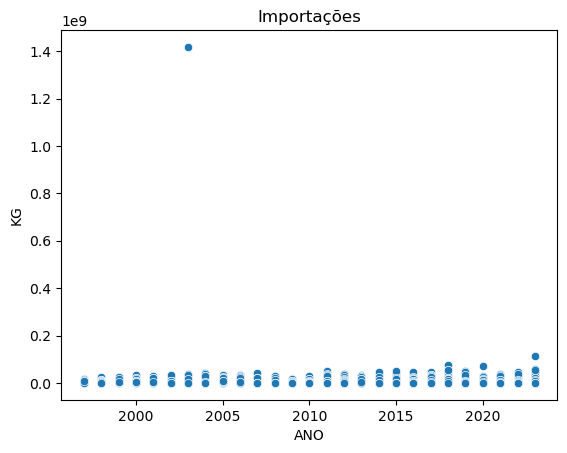

In [5]:
sns.scatterplot(data=i, x='ANO',y='KG').set_title('Importações')

In [6]:
display('Identificando a importação do erro: ', i[i.KG>.2*10**9])

'Identificando a importação do erro: '

,ANO,MES,NCM,PAIS,URF,KG,FOB,FRETE,SEGURO
374,2003,8,31021010,831,517602,1418071545,5604808,293995,0


Veja no gráfico abaixo que, apesar da disproporção do peso, o valor FOB da mesma importação, marcado na cor laranja, não esta tão distantes dos demais valores FOB, estando então dentro da normalidade.

In [7]:
it=i[i.KG>.2*10**9].assign(erro=1)
it2=i.merge(it, how='outer')
it2=it2.replace(np.nan,0)

Text(0.5, 1.0, 'Importações')

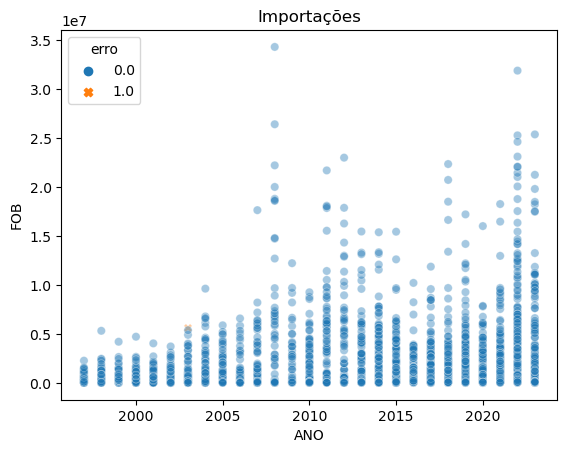

In [8]:
sns.scatterplot(data=it2, x='ANO',y='FOB',hue='erro',style='erro', alpha=0.4).set_title('Importações')

In [9]:
print(f"\n\n\nExcluindo momentâneamente esse erro em questão, o peso líquido em KG e o valor FOB das \
importações apresentam \nelevado coeficiente de correlação, de \
{round(100*it2[it2.erro==0][['KG','FOB']].corr().values[0,1])}%. Isso permite que possamos estimar \
bem o peso líquido em função \ndo valor FOB, e vice versa. \n\nNo caso em questão o erro é sobre o peso \
líquido e a correção será feita através da proporção dele com o valor \nFOB.\n\n\n")




Excluindo momentâneamente esse erro em questão, o peso líquido em KG e o valor FOB das importações apresentam 
elevado coeficiente de correlação, de 82%. Isso permite que possamos estimar bem o peso líquido em função 
do valor FOB, e vice versa. 

No caso em questão o erro é sobre o peso líquido e a correção será feita através da proporção dele com o valor 
FOB.





É possível que esse mesmo tipo de erro, que é um desbalanço entre peso e valor,  possa estar ocorrendo mais vezes na tabela, mas em intensidade menor, que não permita a visualização tão facilmente como no caso acima.

Para corrigir não somente esse erro identificado mas todos os demais do mesmo tipo será utilizado o [_standard score_.](https://en.wikipedia.org/wiki/Standard_score), que aqui será denominado z_score.

In [10]:
q=pd.DataFrame()
for ncm in i.NCM.unique():
    it=i[i.NCM==ncm]
    it=it.assign(z_score_KG=(i.KG-i.KG.mean())/i.KG.std())
    it=it.assign(z_score_FOB=(i.FOB-i.FOB.mean())/i.FOB.std())
    
    q=pd.concat([q,it])
i=q

In [11]:
i=i.assign(z_diff=i.z_score_KG - i.z_score_FOB)

In [12]:
i.sort_values(by='z_diff')

,ANO,MES,NCM,PAIS,URF,KG,FOB,FRETE,SEGURO,z_score_KG,z_score_FOB,z_diff
697,2008,9,31054000,676,517602,28090884,34285937,1821014,25285,0.669911,8.595736,-7.925825
2170,2022,7,31042090,23,517800,44359165,31867608,1320723,7954,1.205051,7.941982,-6.736930
675,2008,6,31054000,676,517602,21363050,26395156,946425,27280,0.448602,6.462595,-6.013994
2188,2022,8,31054000,474,517800,26356000,24605587,853055,31343,0.612843,5.978815,-5.365972
680,2008,7,31054000,249,517602,18214152,22201266,1085993,57546,0.345020,5.328847,-4.983828
...,...,...,...,...,...,...,...,...,...,...,...,...
100,1998,11,31022100,249,517600,11099968,645698,133200,2956,0.111001,-0.498341,0.609342
74,1998,6,31022100,249,517600,11737680,639797,140977,3195,0.131978,-0.499936,0.631914
65,1998,4,31022100,249,517600,12600067,692972,151549,3062,0.160346,-0.485561,0.645907
1478,2017,9,31021010,831,517602,25991059,1936336,259909,1537,0.600838,-0.149439,0.750277


In [13]:
from scipy.stats import norm

/tmp/ipykernel_1662/2056613037.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g=sns.distplot(i.z_diff, fit=norm, kde=False, ax=ax)


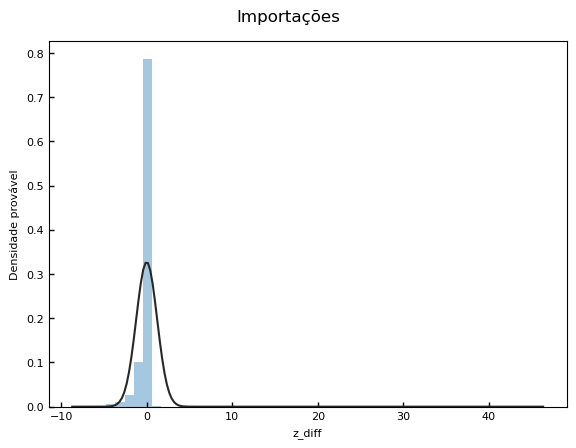

In [14]:
fig, ax=plt.subplots(sharex=True)

g=sns.distplot(i.z_diff, fit=norm, kde=False, ax=ax)
ax.tick_params(axis='x',direction='in',width=1, labelsize=8)
ax.tick_params(axis='y',direction='in',width=1, labelsize=8)
ax.set_ylabel('Densidade provável',fontdict={'fontsize':8})
ax.set_xlabel('z_diff',fontdict={'fontsize':8})

    
fig.tight_layout(pad=3)
fig.suptitle('Importações')

plt.show()

In [15]:
i_z_dif_mean=i.z_diff.mean()
i_z_dif_mean

-6.029212861774291e-17

Como a média se motrou com valor muito próximo a zero, será considerado zero.

In [16]:
i_z_dif_mean=0

In [17]:
i_z_dif_std=i.z_diff.std()
i_z_dif_std

1.2200117091440428

In [18]:
i.loc[((np.abs(i.z_diff)>3*i_z_dif_std)&(np.abs(i.z_score_KG)>(np.abs(i.z_score_FOB)))),'z_score_KG']=i.z_score_FOB
i.loc[((np.abs(i.z_diff)>3*i_z_dif_std)&(np.abs(i.z_score_KG)<=(np.abs(i.z_score_FOB)))),'z_score_FOB']=i.z_score_KG

/tmp/ipykernel_1662/2056613037.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g=sns.distplot(i.z_diff, fit=norm, kde=False, ax=ax)


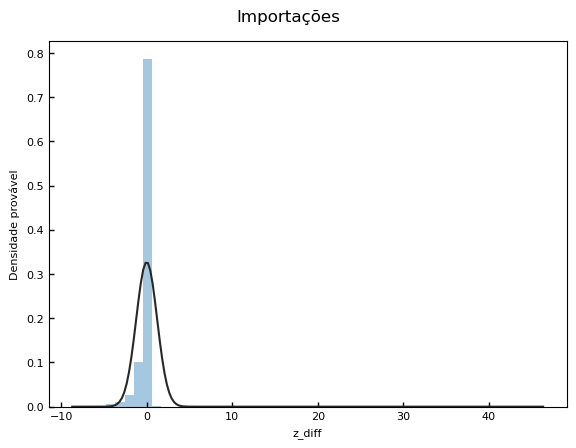

In [19]:
fig, ax=plt.subplots(sharex=True)

g=sns.distplot(i.z_diff, fit=norm, kde=False, ax=ax)
ax.tick_params(axis='x',direction='in',width=1, labelsize=8)
ax.tick_params(axis='y',direction='in',width=1, labelsize=8)
ax.set_ylabel('Densidade provável',fontdict={'fontsize':8})
ax.set_xlabel('z_diff',fontdict={'fontsize':8})

    
fig.tight_layout(pad=3)
fig.suptitle('Importações')

plt.show()

In [20]:
i.KG=i.z_score_KG*i.KG.std()+i.KG.mean()

In [21]:
i=i.drop(columns=['z_score_KG','z_score_FOB'])

In [22]:
q=pd.DataFrame()
for ncm in i.NCM.unique():
    it=i[i.NCM==ncm]
    it=it.assign(z_score_KG=(i.KG-i.KG.mean())/i.KG.std())
    it=it.assign(z_score_FOB=(i.FOB-i.FOB.mean())/i.FOB.std())
    
    q=pd.concat([q,it])
i=q

In [23]:
i.to_csv('~/comex/data/imp3.csv', index=False)